# `eGSIM` tutorial / Residuals

## Define imports and custom functions

In [1]:
import warnings; warnings.filterwarnings("ignore")
import os
import io
import json
from typing import List, Dict, Tuple, Optional
# external libraries (pip install ...):
import requests
import numpy as np  # numeric python (faster numeric array manipoulation)
import pandas as pd  # handling tabular data efficiently (e.g. pd.DataFrame)
import tables  # required by pandas only if you download data in hdf instead of csv
import matplotlib.pyplot as plt  # plotting library

# Juopyter notebook stuff:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display, HTML
# make wide cells display a scrollbar automatically:
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))
from IPython.core.display import HTML
# make tables cells with a border:
display(HTML("<style>th, td{border: 1px solid #DDE !important;}</style>"))


def get_residuals_from_egsim(
    model: List,
    imt: List,
    flatfile: str,
    query_string=None,
    likelihood=False
) -> pd.DataFrame:
    """Retreive the residuals for the flatfile and the selected
    set of ground motion models and intensity measure types

    Args:
        flatfile: Local path to the selected flatfile, or a preloaded flatfile (e.g. "esm2018")
        model: ground motion model(s) (OpenQuake class names)
        imt: intensity measure type(s) (e.g. PGA, PGV, SA(0.1) etc.)
        query_string: Selection query to apply to the data (e.g. "mag>6")
    Returns:
        response: a responses.Response of the POST request. The format depends on the given request parameters
    """ 
    
    # request parameters:
    parameters = {
        'model': model,
        'imt': imt,
        'format': 'hdf' # you can change this to csv, but hdf should be more performant
    }
    if query_string:
        parameters['data-query'] = query_string
    
    # arguments to be passed to `requests.post`. Some of them will be filled depending 
    # on the request type (see if below):
    args = {'data':None, 'json':None, 'files':None}
    
    if not os.path.isfile(flatfile):
        parameters['flatfile'] = flatfile
        args['json'] = parameters
    else:
        args['data'] = parameters
        args['files'] = {'flatfile': open(flatfile, "rb")}

    # POST request for eGSIM
    try:
        response = requests.post(
            "http://127.0.0.1:8000/query/residuals",  # the base request URL for residuals
            **args
        )
        response.raise_for_status() # if server response code denote unsuccessful response, fallbak below
    except requests.exceptions.HTTPError as exc:
        # before raising, print eGSIM error message:
        code = exc.response.status_code
        msg = response.json()['message']
        print(f"HTTPError (code={code}): {msg}")
        raise
    finally:
        # close the open file, if any (regardless of any thrown exception):
        if args['files']:
            args['files']['flatfile'].close()

    # `response.content` is a bytes sequence (in-memory file) representing the
    # result DataFrame, either in CSV or HDF format. Read the conent into a DataFrame:
    if parameters['format'] == 'hdf':
        # `pd.read_hdf` works for HDF files on disk. Workaround:
        with pd.HDFStore(
                "data.h5",  # apparently unused for in-memory data
                mode="r",
                driver="H5FD_CORE",  # create in-memory file
                driver_core_backing_store=0,  # for safety, just in case
                driver_core_image=response.content) as store:
            dframe = store[list(store.keys())[0]]
    else:
        # use `pd.read_csv` with a BytesIO (file-like object) as input: 
        dframe = pd.read_csv(io.BytesIO(response.content), header=[0, 1, 2], index_col=0)
        # workaround to fix pandas renaming emopty cell (rename them back to ""):
        dframe.rename(columns=lambda c: "" if c.startswith("Unnamed:") else c,
                      inplace=True)
    return dframe

## Computing and downloading residuals

We want to compute residuals for two selected models (`BindiEtAl2014Rjb` and `CauzziEtAl2014`) comparing their predicted `PGA` with observed values taken from a pre-loaded Flatfile (`ESM` - https://esm-db.eu/#/home), selecting all flatfile records with magnitude greater than 6, for pure performance reason

⚠️ *the ESM flatfile has roughly 23,000 records (rows) and 84 fields (columns), totalling roughly 14Mb of space in memory. Without selection, a residuals computation like the one we are about to perform - with only two models and one intensity measure - might take up to 1-2 minutes, depending on your internet connection*. ***As such, as a rule of thumb, halve those numbers (&le; 10,000 rows, &le;40 columns, &le; 5-7 Mb) when uploading your user-defined flatfiles***. If you really need to work with bigger data, contact the eGSIM administrators to fiund a feasible solution

In [2]:
residuals = get_residuals_from_egsim(['BindiEtAl2014Rjb', 'CauzziEtAl2014'], ['PGA'], 'esm2018', 'mag>6')
display(residuals)

PGA                                                     \
        total_residual                inter_event_residual                  
      BindiEtAl2014Rjb CauzziEtAl2014     BindiEtAl2014Rjb CauzziEtAl2014   
32            1.069385       0.546405             0.501586       0.350233   
469          -1.531687      -1.839906            -0.718424      -1.179336   
520          -5.916926      -4.470003            -2.775283      -2.865167   
915          -0.852070      -1.243069            -0.399656      -0.796778   
1345         -2.834654      -3.038288                  NaN            NaN   
...                ...            ...                  ...            ...   
23009         0.675737       0.221032            -0.442293      -0.919964   
23010         0.584031       0.174981            -0.442293      -0.919964   
23011        -0.893701      -1.222181            -0.442293      -0.919964   
23012        -0.213235      -0.599475            -0.442293      -0.919964   
23013         0.476251       0.056949            -0.442293      -0.919964   

                                          input_data                        \
      intra_event_residual                  distance             intensity   
          BindiEtAl2014Rjb CauzziEtAl2014        rjb        rrup       PGA   
32                0.944457       0.419399      36.20   36.693869  0.181622   
469              -1.352751      -1.412239     291.10  291.467102  0.000633   
520              -5.225697      -3.430998     291.80  684.830662  0.000029   
915              -0.752529      -0.954131     168.81  170.720000  0.008823   
1345                   NaN            NaN     279.40  281.221150  0.000277   
...                    ...            ...        ...         ...       ...   
23009             1.000016       1.056212      47.96   48.840000  0.096651   
23010             0.896179       0.996216     170.38  170.380000  0.015593   
23011            -0.777023      -0.824046      91.15   91.150000  0.010030   
23012            -0.006547      -0.012767      66.15   66.790000  0.030837   
23013             0.774143       0.842441      13.48   13.650000  0.303831   

                                                              
                     rupture                site              
                      evt_id   mag   rake sta_id        vs30  
32              AM-1988-0001  6.70   90.0     29  463.189878  
469    EMSC-20090907_0000308  6.01   90.0   1340  861.645389  
520    EMSC-20100411_0000035  6.30  -90.0   1341  780.226277  
915    EMSC-20111023_0000031  7.10   63.0   1340  861.645389  
1345   EMSC-20120610_0000062  6.10    0.0    363  439.536266  
...                      ...   ...    ...    ...         ...  
23009           IR-2005-0044  6.44  104.0    632  282.118921  
23010           IR-2005-0044  6.44  104.0    640  414.262878  
23011           IR-2005-0044  6.44  104.0    655  847.076427  
23012           IR-2005-0044  6.44  104.0    678  403.958849  
23013           IR-2005-0044  6.44  104.0    689  329.596506  

[1242 rows x 14 columns]

`residuals` is a `pandas.DataFrame`, i.e. a tabular structure organized in fields (or columns) and records (or rows).
It is composed of a column header with 3 nesting levels, and results from the horizontal (column-wise) concatenation  of the computed residuals and the input data (i.e., the input flatfile stripped of fields that were not relevant for the computation):

<!-- |                   |   |                   |   |                   |   |                   |   |          |   |       |
|-------------------|---|-------------------|---|-------------------|---|-------------------|---|----------|---|-------|
|imt_1                                    |||...|imt_N                                    |||...|`flatfile`          |||
|residual_type_1    |...|residual_type_M    |...|residual_type1     |...|residual_type_M    |...|field_1   |...|field_J|
|model_1 ... model_K|...|model_1 ... model_K|...|model_1 ... model_K|...|model_1 ... model_K|...|                    |||
|-------------------|---|-------------------|---|-------------------|---|-------------------|---|----------|---|-------|
| table body (residuals data)                                                                                ||||||||||| -->

<style>
    th{
        border: 1px solid #DDD;
    }
</style>

<table>
    <tr>
        <th colspan="7">imt<sub>1</sub></code></th>
        <th>...</th>
        <th colspan="7">imt<sub>N</sub></th>
        <th>...</th>
        <th colspan="3">"input_data"</th>
    </tr>
    <tr>
        <th colspan="3">residual_type<sub>1</sub></th>
        <th>...</th>
        <th colspan="3">residual_type<sub>M</sub></th>
        <th>...</th>
        <th colspan="3">residual_type<sub>1</sub></th>
        <th>...</th>
        <th colspan="3">residual_type<sub>M</sub></th>
        <th>...</th>
        <th>field_type</th>
        <th>...</th>
        <th>field_type</th>
    </tr>
    <tr>
        <th>model<sub>1</sub></th><th>...</th><th>model<sub>K</sub></th>
        <th>...</th>
        <th>model<sub>1</sub></th><th>...</th><th>model<sub>K</sub></th>
        <th>...</th>
        <th>model<sub>1</sub></th><th>...</th><th>model<sub>K</sub></th>
        <th>...</th>
        <th>model<sub>1</sub></th><th>...</th><th>model<sub>K</sub></th>
        <th>...</th>
        <th>field_name</th>
        <th>...</th>
        <th>field_name</th>
    </tr>
    <tr><td colspan="19" style='text-align:center'> record<sub>1</sub> data </td></tr>
    <tr><td colspan="19" style='text-align:center'> ... </td></tr>
    <tr><td colspan="19" style='text-align:center'> record<sub>n</sub> data </td></tr>
    </tr>
</table>

### Working with residuals data

In the following, we show a basic data selection and plotting from `residuals` (for further details on pandas DataFrames, see the [official documentation](https://pandas.pydata.org/docs/user_guide/), in particular the sections [Indexing and selecting data](https://pandas.pydata.org/docs/user_guide/indexing.html) and [MultiIndex / advanced indexing](https://pandas.pydata.org/docs/user_guide/advanced.html))

#### Selecting the computed PGA residuals

In [3]:
residuals_pga = residuals['PGA']['total_residual'][:]
# the last [:] means: all sub-columns, and could be omitted
display(residuals_pga)

,BindiEtAl2014Rjb,CauzziEtAl2014
32,1.069385,0.546405
469,-1.531687,-1.839906
520,-5.916926,-4.470003
915,-0.852070,-1.243069
1345,-2.834654,-3.038288
...,...,...
23009,0.675737,0.221032
23010,0.584031,0.174981
23011,-0.893701,-1.222181
23012,-0.213235,-0.599475


#### Selecting the input flatfile

In [4]:
flatfile = residuals['input_data']
display(flatfile)

distance             intensity                rupture               \
           rjb        rrup       PGA                 evt_id   mag   rake   
32       36.20   36.693869  0.181622           AM-1988-0001  6.70   90.0   
469     291.10  291.467102  0.000633  EMSC-20090907_0000308  6.01   90.0   
520     291.80  684.830662  0.000029  EMSC-20100411_0000035  6.30  -90.0   
915     168.81  170.720000  0.008823  EMSC-20111023_0000031  7.10   63.0   
1345    279.40  281.221150  0.000277  EMSC-20120610_0000062  6.10    0.0   
...        ...         ...       ...                    ...   ...    ...   
23009    47.96   48.840000  0.096651           IR-2005-0044  6.44  104.0   
23010   170.38  170.380000  0.015593           IR-2005-0044  6.44  104.0   
23011    91.15   91.150000  0.010030           IR-2005-0044  6.44  104.0   
23012    66.15   66.790000  0.030837           IR-2005-0044  6.44  104.0   
23013    13.48   13.650000  0.303831           IR-2005-0044  6.44  104.0   

        site              
      sta_id        vs30  
32        29  463.189878  
469     1340  861.645389  
520     1341  780.226277  
915     1340  861.645389  
1345     363  439.536266  
...      ...         ...  
23009    632  282.118921  
23010    640  414.262878  
23011    655  847.076427  
23012    678  403.958849  
23013    689  329.596506  

[1242 rows x 8 columns]

#### Selecting the observed PGA

In [5]:
observed_pga = flatfile['intensity']['PGA']
display(observed_pga)

32       0.181622
469      0.000633
520      0.000029
915      0.008823
1345     0.000277
           ...   
23009    0.096651
23010    0.015593
23011    0.010030
23012    0.030837
23013    0.303831
Name: PGA, Length: 1242, dtype: float64

### Basic plotting

Let's plot the predicted data against magnitude (via matplotlib `plt`):

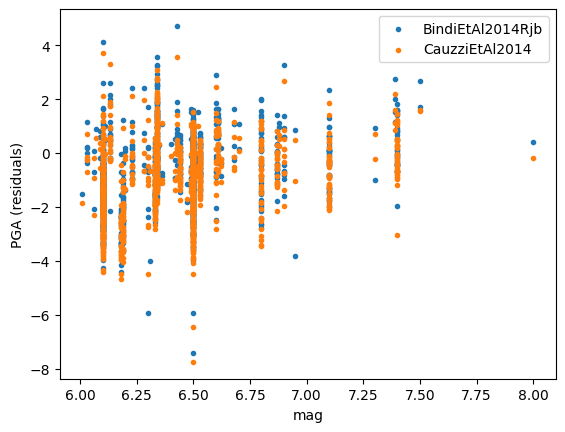

In [6]:
for model in ['BindiEtAl2014Rjb', 'CauzziEtAl2014']:
    plt.scatter(x=flatfile['rupture']['mag'], y=residuals_pga[model], label=model, marker='.')
plt.xlabel('mag')
plt.ylabel('PGA (residuals)')
plt.legend()

or using the pandas plot method (calling internally matplotlib):

<Axes: xlabel='mag', ylabel='PGA (residuals)'>

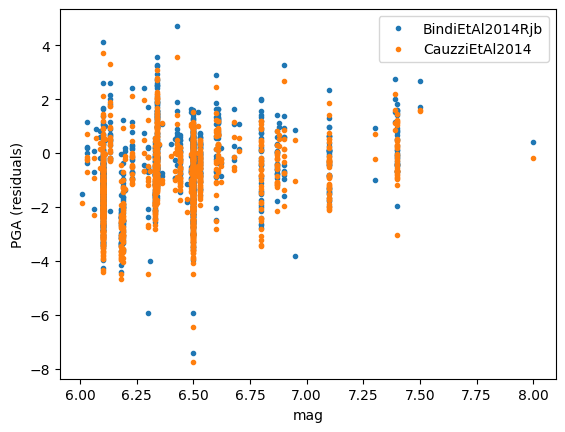

In [7]:
# create a new dataframe by appending the observed magnitudes to the predicted PGA residuals:
plot_dataframe = residuals_pga.copy()
plot_dataframe['mag'] = flatfile['rupture']['mag']
# plot:
plot_dataframe.plot(x='mag', style=".", ylabel='PGA (residuals)')